# Machine Learning Nanodegree - Capstone Project
## Google Analytics Customer Revenue Prediction 

### Importing the needed Libraries used for the project, 
the libraries included are used for following functions 

- Data Processing
- Data Exploration 
- Data Visualization 
- Model Selection
- Model Evaluation 


In [1]:
# Libraries for Data Processing and Exploration
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import datetime 
from scipy.stats import kurtosis, skew

# Libraries for Data Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import plotly.offline as py
import plotly.graph_objs as go
from plotly import tools
from plotly.offline import init_notebook_mode, iplot, plot 

py.init_notebook_mode(connected=True)

%matplotlib inline

# Librabies for Building and Evaluating the Model

from sklearn import model_selection, preprocessing, metrics
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor

## Data Exploration

The Data is loaded in chunks to distribute the computing and the JSON columns are converted into seperate features

In [2]:
%%time

# The CSV files with JSON columns to be converted are passed as input

def load_df(csv_path='train_v2.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    df = pd.DataFrame([])
    for chunk in pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'},
                     chunksize=nrows):

        chunk = chunk.drop(['customDimensions','hits'], axis=1)
        df = df.append(chunk, ignore_index=True)
        print(df.shape[0])
    print("Dataframe assembled; Working on JSON columns...")
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print("Done!")
    return df

# Load Train data 
train = load_df('train_v2.csv', 100000)
train["totals.transactionRevenue"] = train["totals.transactionRevenue"].astype('float')

100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1708337
Dataframe assembled; Working on JSON columns...
Done!
Wall time: 9min 14s


In [3]:
# Load Test data 
test = load_df('test_v2.csv', 100000)
test["totals.transactionRevenue"] = test["totals.transactionRevenue"].astype('float')

100000
200000
300000
400000
401589
Dataframe assembled; Working on JSON columns...
Done!


In [4]:
train.head()

,channelGrouping,date,fullVisitorId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,device.browserVersion,...,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,20171016,3162355547410993243,Not Socially Engaged,1508198450,1,1508198450,Firefox,not available in demo dataset,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,water bottle,organic,NaN,google
1,Referral,20171016,8934116514970143966,Not Socially Engaged,1508176307,6,1508176307,Chrome,not available in demo dataset,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,NaN,referral,/a/google.com/transportation/mtv-services/bike...,sites.google.com
2,Direct,20171016,7992466427990357681,Not Socially Engaged,1508201613,1,1508201613,Chrome,not available in demo dataset,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,True,NaN,(none),NaN,(direct)
3,Organic Search,20171016,9075655783635761930,Not Socially Engaged,1508169851,1,1508169851,Chrome,not available in demo dataset,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
4,Organic Search,20171016,6960673291025684308,Not Socially Engaged,1508190552,1,1508190552,Chrome,not available in demo dataset,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google


### Total Columns
The complete dataset is loaded which has about 1708337 entries. 
There are 12 original columns, but four of them have a json object that can be converted:

- device: 16 new columns
- geoNetwork: 11 new columns
- totals: 6 new columns
- trafficSource: 14 new columns

Total there are `55 columns` including the target valriable `totals.transactionRevenue`.

In [5]:
train.describe()

,date,visitId,visitNumber,visitStartTime,totals.transactionRevenue
count,1.708337e+06,1.708337e+06,1.708337e+06,1.708337e+06,1.851400e+04
mean,2.017016e+07,1.498352e+09,2.335170e+00,1.498352e+09,1.251132e+08
std,6.485620e+03,1.624937e+07,9.354034e+00,1.624937e+07,4.162653e+08
min,2.016080e+07,1.470035e+09,1.000000e+00,1.470035e+09,1.000000e+04
25%,2.016122e+07,1.482738e+09,1.000000e+00,1.482738e+09,2.306750e+07
50%,2.017071e+07,1.499832e+09,1.000000e+00,1.499832e+09,4.606000e+07
75%,2.017120e+07,1.512513e+09,1.000000e+00,1.512513e+09,1.000000e+08
max,2.018043e+07,1.525158e+09,4.570000e+02,1.525158e+09,2.312950e+10


### Customer Transaction 

In [6]:
gdf = train.groupby("fullVisitorId")["totals.transactionRevenue"].sum().reset_index()
non_zero_revenue = pd.notnull(train["totals.transactionRevenue"]).sum()

non_zero_customers = (gdf["totals.transactionRevenue"]>0).sum()

unique_customers = train.fullVisitorId.nunique()
unique_customers_test = test.fullVisitorId.nunique()

print("Number of unique visitors in train set : ",train.fullVisitorId.nunique(), " out of rows : ",train.shape[0])


print("Number of instances in train set with non-zero revenue : ", non_zero_revenue, "of",train.shape[0]," and ratio is : ", non_zero_revenue / train.shape[0])
print("Number of unique customers with non-zero revenue : ", non_zero_customers,"of",gdf.shape[0], "and the ratio is : ", non_zero_customers / gdf.shape[0])

print("Number of unique visitors in train set : ",unique_customers, " out of rows : ",train.shape[0])
print("Number of unique visitors in test set : ",unique_customers_test, " out of rows : ",test.shape[0])
print("Number of common visitors in train and test set : ",len(set(train.fullVisitorId.unique()).intersection(set(test.fullVisitorId.unique())) ))

Number of unique visitors in train set :  1323730  out of rows :  1708337
Number of instances in train set with non-zero revenue :  18514 of 1708337  and ratio is :  0.010837440153786987
Number of unique customers with non-zero revenue :  16141 of 1323730 and the ratio is :  0.012193574218307359
Number of unique visitors in train set :  1323730  out of rows :  1708337
Number of unique visitors in test set :  296530  out of rows :  401589
Number of common visitors in train and test set :  2759


In [7]:
train.head()

,channelGrouping,date,fullVisitorId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,device.browserVersion,...,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,20171016,3162355547410993243,Not Socially Engaged,1508198450,1,1508198450,Firefox,not available in demo dataset,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,water bottle,organic,NaN,google
1,Referral,20171016,8934116514970143966,Not Socially Engaged,1508176307,6,1508176307,Chrome,not available in demo dataset,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,NaN,referral,/a/google.com/transportation/mtv-services/bike...,sites.google.com
2,Direct,20171016,7992466427990357681,Not Socially Engaged,1508201613,1,1508201613,Chrome,not available in demo dataset,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,True,NaN,(none),NaN,(direct)
3,Organic Search,20171016,9075655783635761930,Not Socially Engaged,1508169851,1,1508169851,Chrome,not available in demo dataset,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
4,Organic Search,20171016,6960673291025684308,Not Socially Engaged,1508190552,1,1508190552,Chrome,not available in demo dataset,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google


### Find Columns with Missing values

In [8]:
def missing_values(data):
    total = data.isnull().sum().sort_values(ascending = False) # getting the sum of null values and ordering
    percent = (data.isnull().sum() / data.isnull().count() * 100 ).sort_values(ascending = False) #getting the percent and order of null
    df = pd.concat([total, percent], axis=1, keys=['Total', 'Percent']) # Concatenating the total and percent
    print("Total columns at least one Values: ")
    print (df[~(df['Total'] == 0)]) # Returning values of nulls different of 0
    
    print("\n Total of Sales % of Total: ", round((train[train['totals.transactionRevenue'] != np.nan]['totals.transactionRevenue'].count() / len(train['totals.transactionRevenue']) * 100),4))
    
    return 


In [9]:
missing_values(train)

Total columns at least one Values: 
                                                Total    Percent
trafficSource.campaignCode                    1708336  99.999941
totals.totalTransactionRevenue                1689823  98.916256
totals.transactionRevenue                     1689823  98.916256
totals.transactions                           1689778  98.913622
trafficSource.adContent                       1643600  96.210525
trafficSource.adwordsClickInfo.slot           1633063  95.593727
trafficSource.adwordsClickInfo.page           1633063  95.593727
trafficSource.adwordsClickInfo.isVideoAd      1633063  95.593727
trafficSource.adwordsClickInfo.adNetworkType  1633063  95.593727
trafficSource.adwordsClickInfo.gclId          1632914  95.585005
trafficSource.isTrueDirect                    1173819  68.711209
trafficSource.referralPath                    1142073  66.852910
trafficSource.keyword                         1052780  61.626014
totals.timeOnSite                              874294 

In [10]:
train_const = [c for c in train.columns if len(train[c].unique()) == 1]
test_const = [c for c in test.columns if len(test[c].unique()) == 1]

print("The Columns with only one unique value is equal in Test and Train dataset: ",train_const == test_const)

print("Variables not in test but in train : ", set(train.columns).difference(set(test.columns)))

train_const

The Columns with only one unique value is equal in Test and Train dataset:  True
Variables not in test but in train :  {'trafficSource.campaignCode'}


['socialEngagementType',
 'device.browserSize',
 'device.browserVersion',
 'device.flashVersion',
 'device.language',
 'device.mobileDeviceBranding',
 'device.mobileDeviceInfo',
 'device.mobileDeviceMarketingName',
 'device.mobileDeviceModel',
 'device.mobileInputSelector',
 'device.operatingSystemVersion',
 'device.screenColors',
 'device.screenResolution',
 'geoNetwork.cityId',
 'geoNetwork.latitude',
 'geoNetwork.longitude',
 'geoNetwork.networkLocation',
 'totals.visits',
 'trafficSource.adwordsClickInfo.criteriaParameters']

In [11]:
# Remove columns from Train and Test which have only one unique value
train.drop(train_const,axis = 1, inplace = True)
test.drop(test_const,axis = 1, inplace = True)

# Remove the column present in train but not in test
train.drop(['trafficSource.campaignCode'],axis = 1, inplace = True)

In [12]:
test.head()

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,...,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,20180511,7460955084541987166,1526099341,2,1526099341,Chrome,mobile,True,Android,...,NaN,NaN,NaN,NaN,(not set),True,(not provided),organic,(not set),google
1,Direct,20180511,460252456180441002,1526064483,166,1526064483,Chrome,desktop,False,Macintosh,...,NaN,NaN,NaN,NaN,(not set),True,(not set),(none),(not set),(direct)
2,Organic Search,20180511,3461808543879602873,1526067157,2,1526067157,Chrome,desktop,False,Chrome OS,...,NaN,NaN,NaN,NaN,(not set),True,(not provided),organic,(not set),google
3,Direct,20180511,975129477712150630,1526107551,4,1526107551,Chrome,mobile,True,iOS,...,NaN,NaN,NaN,NaN,(not set),True,(not set),(none),(not set),(direct)
4,Organic Search,20180511,8381672768065729990,1526060254,1,1526060254,Internet Explorer,tablet,True,Windows,...,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,(not set),google


In [13]:
# Impute 0 for missing target values
train["totals.transactionRevenue"].fillna(0, inplace=True)
train_y = train["totals.transactionRevenue"].values
train_id = train["fullVisitorId"].values
test_id = test["fullVisitorId"].values

num_cols = ["totals.hits", "totals.pageviews", "visitNumber", "visitStartTime", 'totals.bounces',  'totals.newVisits']    
for col in num_cols:
    train[col] = train[col].astype(float)
    test[col] = test[col].astype(float)

    
train['date'] = train['date'].apply(lambda x: datetime.date(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:])))    
test['date'] = test['date'].apply(lambda x: datetime.date(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:])))

In [14]:
train.head()

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,...,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,2017-10-16,3162355547410993243,1508198450,1.0,1.508198e+09,Firefox,desktop,False,Windows,...,NaN,NaN,NaN,NaN,(not set),NaN,water bottle,organic,NaN,google
1,Referral,2017-10-16,8934116514970143966,1508176307,6.0,1.508176e+09,Chrome,desktop,False,Chrome OS,...,NaN,NaN,NaN,NaN,(not set),NaN,NaN,referral,/a/google.com/transportation/mtv-services/bike...,sites.google.com
2,Direct,2017-10-16,7992466427990357681,1508201613,1.0,1.508202e+09,Chrome,mobile,True,Android,...,NaN,NaN,NaN,NaN,(not set),True,NaN,(none),NaN,(direct)
3,Organic Search,2017-10-16,9075655783635761930,1508169851,1.0,1.508170e+09,Chrome,desktop,False,Windows,...,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
4,Organic Search,2017-10-16,6960673291025684308,1508190552,1.0,1.508191e+09,Chrome,desktop,False,Windows,...,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google


## Data Analysis


### Visualization of Revenue Generated

Looking at the revenue graph over the user ID the revenue generated is only from a small group of people. 

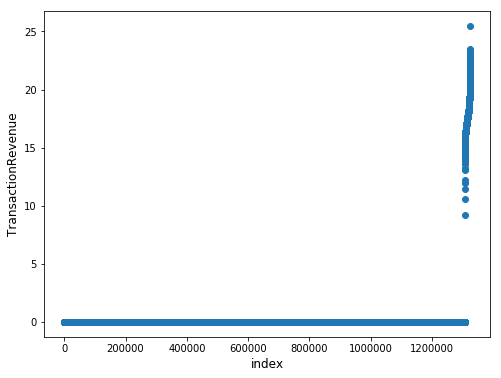

In [15]:

plt.figure(figsize=(8,6))
plt.scatter(range(gdf.shape[0]), np.sort(np.log1p(gdf["totals.transactionRevenue"].values)))
plt.xlabel('index', fontsize=12)
plt.ylabel('TransactionRevenue', fontsize=12)
plt.show()

There are 18514 visitors in the train dataset having non zero total transaction revenue
Excess kurtosis of normal distribution (should be 0): 977.3931553933475
Skewness of normal distribution (should be 0): 24.886753584643646


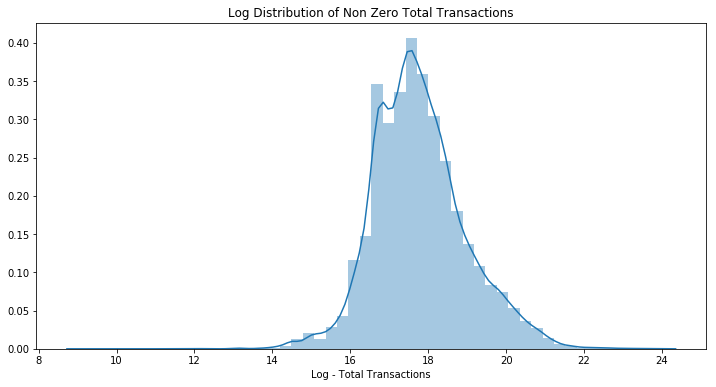

In [16]:
non_zero = train[train["totals.transactionRevenue"] > 0]["totals.transactionRevenue"]
print ("There are " + str(len(non_zero)) + " visitors in the train dataset having non zero total transaction revenue")

plt.figure(figsize=(12,6))
sns.distplot(np.log1p(non_zero))
plt.title("Log Distribution of Non Zero Total Transactions");
plt.xlabel("Log - Total Transactions");

print('Excess kurtosis of normal distribution (should be 0): {}'.format(
    kurtosis(train[train['totals.transactionRevenue'] > 0]["totals.transactionRevenue"])))
print( 'Skewness of normal distribution (should be 0): {}'.format(
    skew((train[train['totals.transactionRevenue'] > 0]["totals.transactionRevenue"]))))

In [21]:
time_visit_hits = train.groupby('date')['totals.pageviews'].agg('count')
time_rev_non_zero = train.groupby('date')['totals.transactionRevenue'].apply(lambda train: (train != 0).sum())
time_rev_total = train.groupby('date')['totals.transactionRevenue'].sum()

time_visit_hits = time_visit_hits.sort_index()
time_rev_non_zero = time_rev_non_zero.sort_index()
time_rev_total = time_rev_total.sort_index()

time_visit_hits = go.Scatter( x=time_visit_hits.index,y=time_visit_hits.values,showlegend=False)
time_rev_non_zero = go.Scatter( x=time_rev_non_zero .index,y=time_rev_non_zero .values,showlegend=False)
time_rev_total= go.Scatter( x=time_rev_total.index,y=time_rev_total.values,showlegend=False)


fig = tools.make_subplots(rows=3, cols=1, vertical_spacing=0.08,subplot_titles=["Date - Page views Count",'Date - Total Non Zero Revenue Generated Count',"Date - Total Revenue"])
fig.append_trace(time_visit_hits, 1, 1)
fig.append_trace(time_rev_non_zero, 2, 1)
fig.append_trace(time_rev_total, 3, 1)

fig['layout'].update(height=800, width=1000, paper_bgcolor='rgb(233,233,233)', title="Date Plots")
py.iplot(fig, filename='date-plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]
[ (3,1) x3,y3 ]



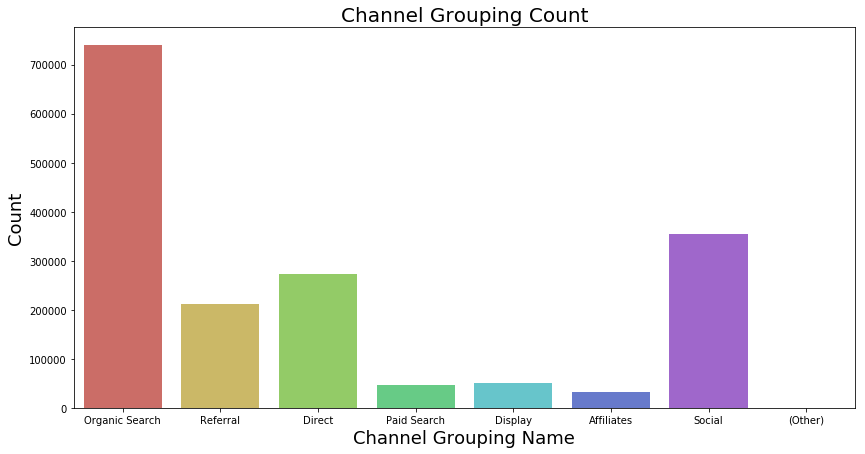

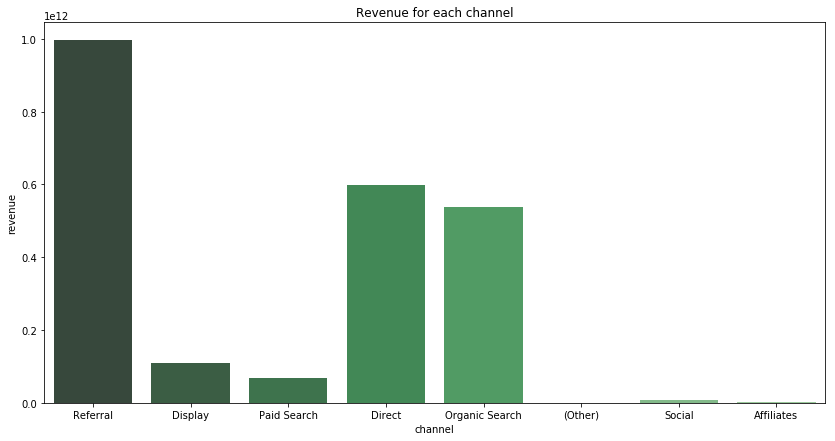

In [22]:
# seting the graph size
plt.figure(figsize=(14,7))

# let explore the browser used by users
sns.countplot(train["channelGrouping"], palette="hls") # It's a module to count the category's
plt.title("Channel Grouping Count", fontsize=20) # seting the title size
plt.xlabel("Channel Grouping Name", fontsize=18) # seting the x label size
plt.ylabel("Count", fontsize=18) # seting the y label size

plt.show() #use plt.show to render the graph that we did above

channel_order = ['Referral', 'Display', 'Paid Search', 'Direct', 'Organic Search', '(Other)', 'Social', 'Affiliates']
revenue_channel = train.groupby('channelGrouping')['totals.transactionRevenue'].sum()
revenue_channel = revenue_channel.to_frame().reset_index()
revenue_channel.columns=['channel', 'revenue']

plt.figure(figsize=(14,7))

plt.title("Revenue for each channel")
ax = sns.barplot(x=revenue_channel.channel, y=revenue_channel.revenue, data=revenue_channel, order=channel_order, palette='Greens_d')

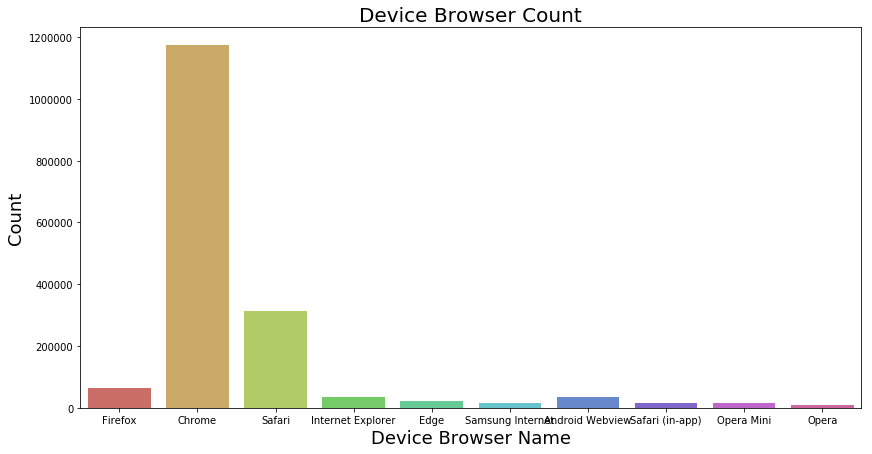

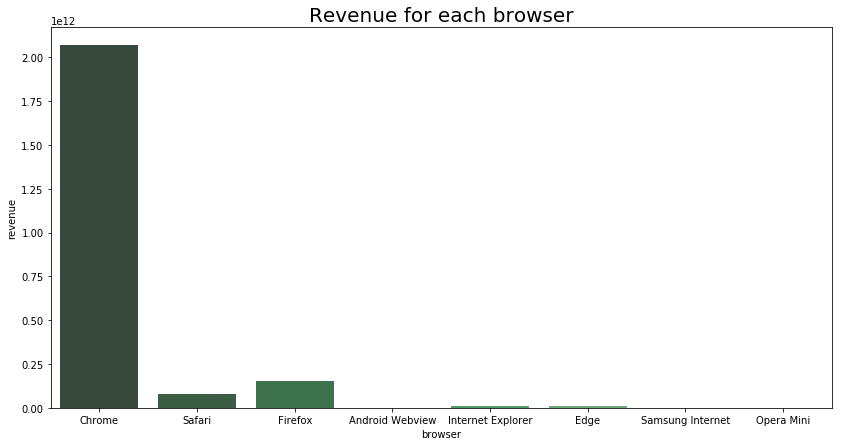

In [23]:
# seting the graph size
plt.figure(figsize=(14,7))

# let explore the browser used by users
sns.countplot(train[train['device.browser']\
                       .isin(train['device.browser']\
                             .value_counts()[:10].index.values)]['device.browser'], palette="hls") # It's a module to count the category's
plt.title("Device Browser Count", fontsize=20) # seting the title size
plt.xlabel("Device Browser Name", fontsize=18) # seting the x label size
plt.ylabel("Count", fontsize=18) # seting the y label size

plt.show() #use plt.show to render the graph that we did above

browser_order = ['Chrome', 'Safari', 'Firefox', 'Android Webview', 'Internet Explorer', 'Edge', 'Samsung Internet', 'Opera Mini']

revenue_browser = train.groupby('device.browser')['totals.transactionRevenue'].sum()
revenue_browser = revenue_browser.to_frame().reset_index()
revenue_browser.columns=['browser', 'revenue']
plt.figure(figsize=(14,7))

plt.title("Revenue for each browser", fontsize=20)
ax = sns.barplot(x=revenue_browser.browser, y=revenue_browser.revenue, data=revenue_browser, order=browser_order, palette='Greens_d')

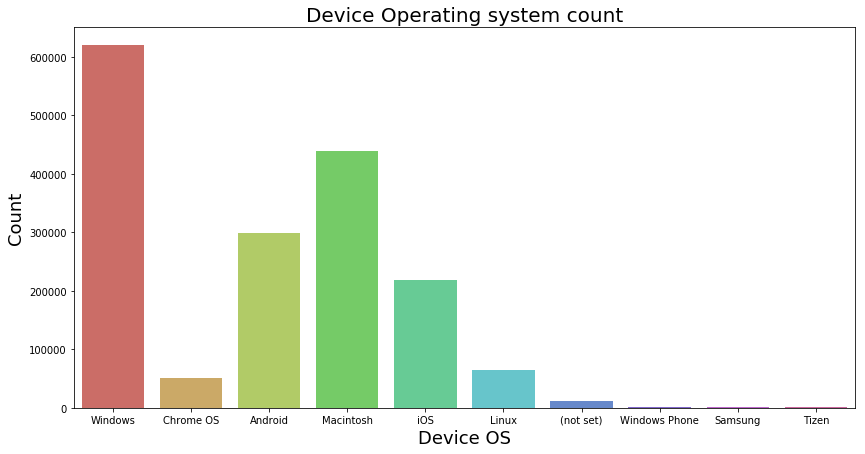

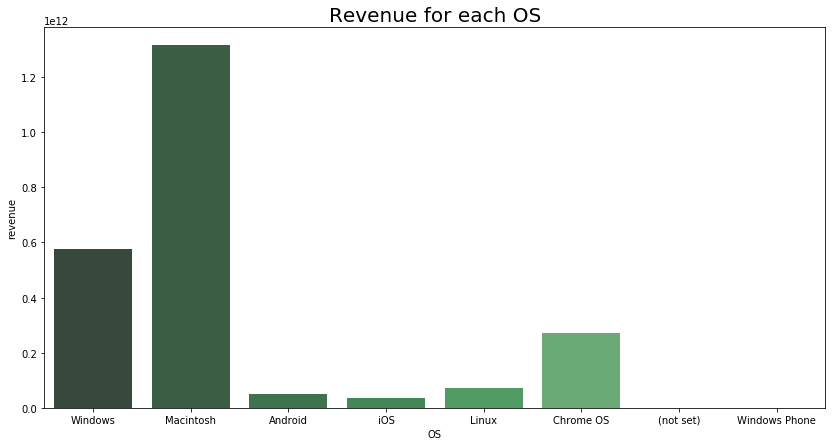

In [24]:
# seting the graph size
plt.figure(figsize=(14,7))

# let explore the browser used by users
sns.countplot(train[train['device.operatingSystem']\
                       .isin(train['device.operatingSystem']\
                             .value_counts()[:10].index.values)]['device.operatingSystem'], palette="hls") # It's a module to count the category's
plt.title("Device Operating system count", fontsize=20) # seting the title size
plt.xlabel("Device OS", fontsize=18) # seting the x label size
plt.ylabel("Count", fontsize=18) # seting the y label size

plt.show() #use plt.show to render the graph that we did above

OS_order = ['Windows', 'Macintosh', 'Android', 'iOS', 'Linux', 'Chrome OS', '(not set)', 'Windows Phone']

revenue_OS = train.groupby('device.operatingSystem')['totals.transactionRevenue'].sum()
revenue_OS = revenue_OS.to_frame().reset_index()
revenue_OS.columns=['OS', 'revenue']

plt.figure(figsize=(14,7))

plt.title("Revenue for each OS", fontsize=20)
ax = sns.barplot(x=revenue_OS.OS, y=revenue_OS.revenue, data=revenue_OS, order=OS_order, palette='Greens_d')

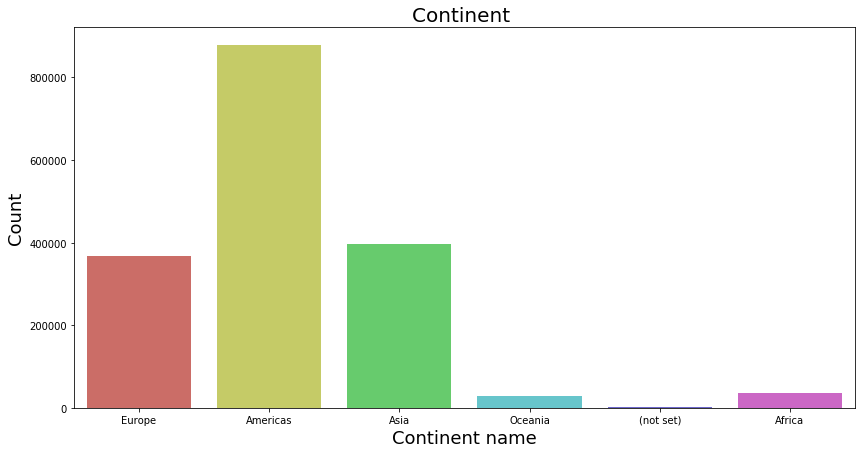

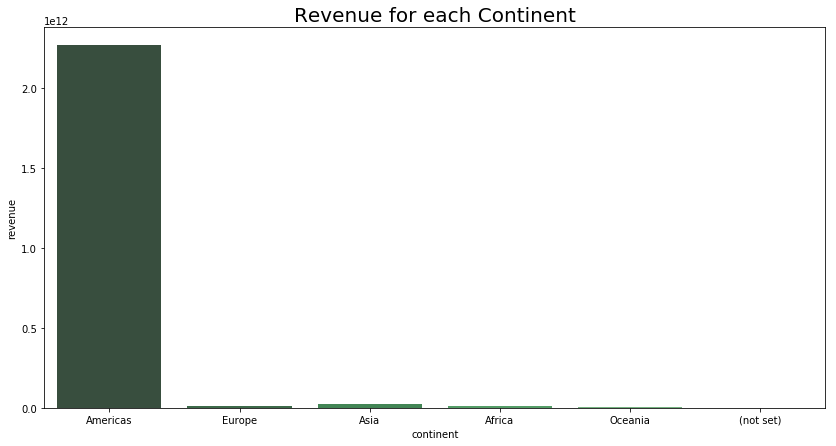

In [25]:
# seting the graph size
plt.figure(figsize=(14,7))

# let explore the browser used by users
sns.countplot(train[train['geoNetwork.continent']\
                       .isin(train['geoNetwork.continent']\
                             .value_counts()[:10].index.values)]['geoNetwork.continent'], palette="hls") # It's a module to count the category's
plt.title("Continent ", fontsize=20) # seting the title size
plt.xlabel("Continent name", fontsize=18) # seting the x label size
plt.ylabel("Count", fontsize=18) # seting the y label size

plt.show() #use plt.show to render the graph that we did above


continent_order = ['Americas', 'Europe', 'Asia', 'Africa', 'Oceania', '(not set)']

revenue_continent = train.groupby('geoNetwork.continent')['totals.transactionRevenue'].sum()
revenue_continent = revenue_continent.to_frame().reset_index()
revenue_continent.columns=['continent', 'revenue']

plt.figure(figsize=(14,7))

plt.title("Revenue for each Continent", fontsize=20)
ax = sns.barplot(x=revenue_continent.continent, y=revenue_continent.revenue, data=revenue_continent, order=continent_order, palette='Greens_d')


In [26]:

# Counting total visits by countrys
countMaps = pd.DataFrame(train['geoNetwork.country'].value_counts()).reset_index()
countMaps.columns=['country', 'counts'] #renaming columns
countMaps = countMaps.reset_index().drop('index', axis=1) #reseting index and droping the column

data = [ dict(
        type = 'choropleth',
        locations = countMaps['country'],
        locationmode = 'country names',
        z = countMaps['counts'],
        text = countMaps['country'],
        autocolorscale = False,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            autotick = False,
            tickprefix = '',
            title = 'Number of Visits'),
      ) ]

layout = dict(
    title = 'Visits Per Country',
    geo = dict(
        showframe = False,
        showcoastlines = True,
        projection = dict(
            type = 'Mercator'
        )
    )
)

figure = dict( data=data, layout=layout )
iplot(figure, validate=False, filename='map-countrys-count')

# I will crete a variable of Revenues by country sum
sumRevMaps = train[train['totals.transactionRevenue'] > 0].groupby("geoNetwork.country")["totals.transactionRevenue"].sum().to_frame().reset_index()
sumRevMaps.columns = ["country", "count_sales"] # renaming columns
sumRevMaps = sumRevMaps.reset_index().drop('index', axis=1) #reseting index and drop index column

data = [ dict(
        type = 'choropleth',
        locations = sumRevMaps['country'],
        locationmode = 'country names',
        z = sumRevMaps['count_sales'],
        text = sumRevMaps['country'],
        autocolorscale = False,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            autotick = False,
            tickprefix = '',
            title = 'Count of Sales'),
      ) ]

layout = dict(
    title = 'Total Sales by Country',
    geo = dict(
        showframe = False,
        showcoastlines = True,
        projection = dict(
            type = 'Mercator'
        )
    )
)

figure = dict( data=data, layout=layout )

iplot(figure, validate=False, filename='map-countrys-total')


## Data Processing

In [27]:

# label encode the categorical variables and convert the numerical variables to float
cat_cols = ["channelGrouping", "device.browser", 
            "device.deviceCategory", "device.operatingSystem", 
            "geoNetwork.city", "geoNetwork.continent", 
            "geoNetwork.country", "geoNetwork.metro",
            "geoNetwork.networkDomain", "geoNetwork.region", 
            "geoNetwork.subContinent", "trafficSource.adContent", 
            "trafficSource.adwordsClickInfo.adNetworkType", 
            "trafficSource.adwordsClickInfo.gclId", 
            "trafficSource.adwordsClickInfo.page", 
            "trafficSource.adwordsClickInfo.slot", "trafficSource.campaign",
            "trafficSource.keyword", "trafficSource.medium", 
            "trafficSource.referralPath", "trafficSource.source",
            'trafficSource.adwordsClickInfo.isVideoAd', 'trafficSource.isTrueDirect']
for col in cat_cols:
    print(col)
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(train[col].values.astype('str')) + list(test[col].values.astype('str')))
    train[col] = lbl.transform(list(train[col].values.astype('str')))
    test[col] = lbl.transform(list(test[col].values.astype('str')))


channelGrouping
device.browser
device.deviceCategory
device.operatingSystem
geoNetwork.city
geoNetwork.continent
geoNetwork.country
geoNetwork.metro
geoNetwork.networkDomain
geoNetwork.region
geoNetwork.subContinent
trafficSource.adContent
trafficSource.adwordsClickInfo.adNetworkType
trafficSource.adwordsClickInfo.gclId
trafficSource.adwordsClickInfo.page
trafficSource.adwordsClickInfo.slot
trafficSource.campaign
trafficSource.keyword
trafficSource.medium
trafficSource.referralPath
trafficSource.source
trafficSource.adwordsClickInfo.isVideoAd
trafficSource.isTrueDirect


In [28]:
print('Excess kurtosis of normal distribution (should be 0): {}'.format(
    kurtosis(train[train['totals.transactionRevenue'] > 0]["totals.transactionRevenue"])))
print( 'Skewness of normal distribution (should be 0): {}'.format(
    skew((train[train['totals.transactionRevenue'] > 0]["totals.transactionRevenue"]))))

Excess kurtosis of normal distribution (should be 0): 977.3931553933475
Skewness of normal distribution (should be 0): 24.886753584643646


In [29]:
# Split the train dataset into development and valid based on time 
dev_df = train[train['date']<=datetime.date(2017,5,31)]
val_df = train[train['date']>datetime.date(2017,5,31)]
dev_y = np.log1p(dev_df["totals.transactionRevenue"].values)
val_y = np.log1p(val_df["totals.transactionRevenue"].values)

dev_X = dev_df[cat_cols + num_cols] 
val_X = val_df[cat_cols + num_cols] 
test_X = test[cat_cols + num_cols] 

In [30]:
print(missing_values(dev_X))
print(missing_values(val_X))
print(len(train.columns))
print(len(dev_X.columns))
print("Variables not in test but in train : ", set(train.columns).difference(set(dev_X.columns)))

Total columns at least one Values: 
                   Total    Percent
totals.bounces    384426  50.205366
totals.newVisits  167463  21.870376
totals.pageviews      77   0.010056

 Total of Sales % of Total:  100.0
None
Total columns at least one Values: 
                   Total    Percent
totals.bounces    452333  47.986272
totals.newVisits  233444  24.765178
totals.pageviews     162   0.017186

 Total of Sales % of Total:  100.0
None
38
29
Variables not in test but in train :  {'totals.totalTransactionRevenue', 'totals.timeOnSite', 'fullVisitorId', 'visitId', 'date', 'totals.sessionQualityDim', 'totals.transactions', 'totals.transactionRevenue', 'device.isMobile'}


In [31]:
missing_cols = ['totals.bounces','totals.newVisits','totals.pageviews']
print(missing_cols)

['totals.bounces', 'totals.newVisits', 'totals.pageviews']


In [32]:
for i in missing_cols:
    if i == "totals.bounces":
        dev_X[i].fillna(0, inplace=True)
        val_X[i].fillna(0, inplace=True)
    else:
        dev_X[i].fillna(1, inplace=True)
        val_X[i].fillna(1, inplace=True)

C:\Users\Forge\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\pandas\core\generic.py:5430: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



## Implementation

### Random Forest Regressor

In [33]:
rf = RandomForestRegressor(n_estimators=20, random_state=0)  
rf.fit(dev_X, dev_y)  
y_pred = rf.predict(val_X)  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_pred,val_y)))  

Root Mean Squared Error: 1.6661387961130436


### Random Forest Prediction for sum of log of revenue for each user

In [34]:
y_pred[y_pred<0] = 0
y_pred_df = pd.DataFrame({"fullVisitorId":val_df["fullVisitorId"].values})
y_pred_df["transactionRevenue"] = val_df["totals.transactionRevenue"].values
y_pred_df["PredictedRevenue"] = np.expm1(y_pred)

#print(np.sqrt(metrics.mean_squared_error(np.log1p(val_pred_df["transactionRevenue"].values), np.log1p(val_pred_df["PredictedRevenue"].values))))
y_pred_df = y_pred_df.groupby("fullVisitorId")["transactionRevenue", "PredictedRevenue"].sum().reset_index()
print("The Random Forest Model's RMSE score for natural log of the sum of all transaction by the user")
print('Root Mean Squared Error:',np.sqrt(metrics.mean_squared_error(np.log1p(y_pred_df["transactionRevenue"].values), np.log1p(y_pred_df["PredictedRevenue"].values))))

The Random Forest Model's RMSE score for natural log of the sum of all transaction by the user
Root Mean Squared Error: 1.6712519936124848


### Decision Tree Regressor

In [35]:
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state=0)
regressor.fit(dev_X, dev_y)  
y_dt = regressor.predict(val_X)  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_dt,val_y)))  

Root Mean Squared Error: 2.4351505282681387


### Decision Tree Prediction for sum of log of revenue for each user

In [36]:
y_dt[y_dt<0] = 0
y_dt_df = pd.DataFrame({"fullVisitorId":val_df["fullVisitorId"].values})
y_dt_df["transactionRevenue"] = val_df["totals.transactionRevenue"].values
y_dt_df["PredictedRevenue"] = np.expm1(y_dt)

#print(np.sqrt(metrics.mean_squared_error(np.log1p(val_pred_df["transactionRevenue"].values), np.log1p(val_pred_df["PredictedRevenue"].values))))
y_dt_df = y_dt_df.groupby("fullVisitorId")["transactionRevenue", "PredictedRevenue"].sum().reset_index()
print("The Decision Tree Model's RMSE score for natural log of the sum of all transaction by the user")

print('Root Mean Squared Error:',np.sqrt(metrics.mean_squared_error(np.log1p(y_dt_df["transactionRevenue"].values), np.log1p(y_dt_df["PredictedRevenue"].values))))

The Decision Tree Model's RMSE score for natural log of the sum of all transaction by the user
Root Mean Squared Error: 2.430840217853144


### Random Forest Feature importance visualization

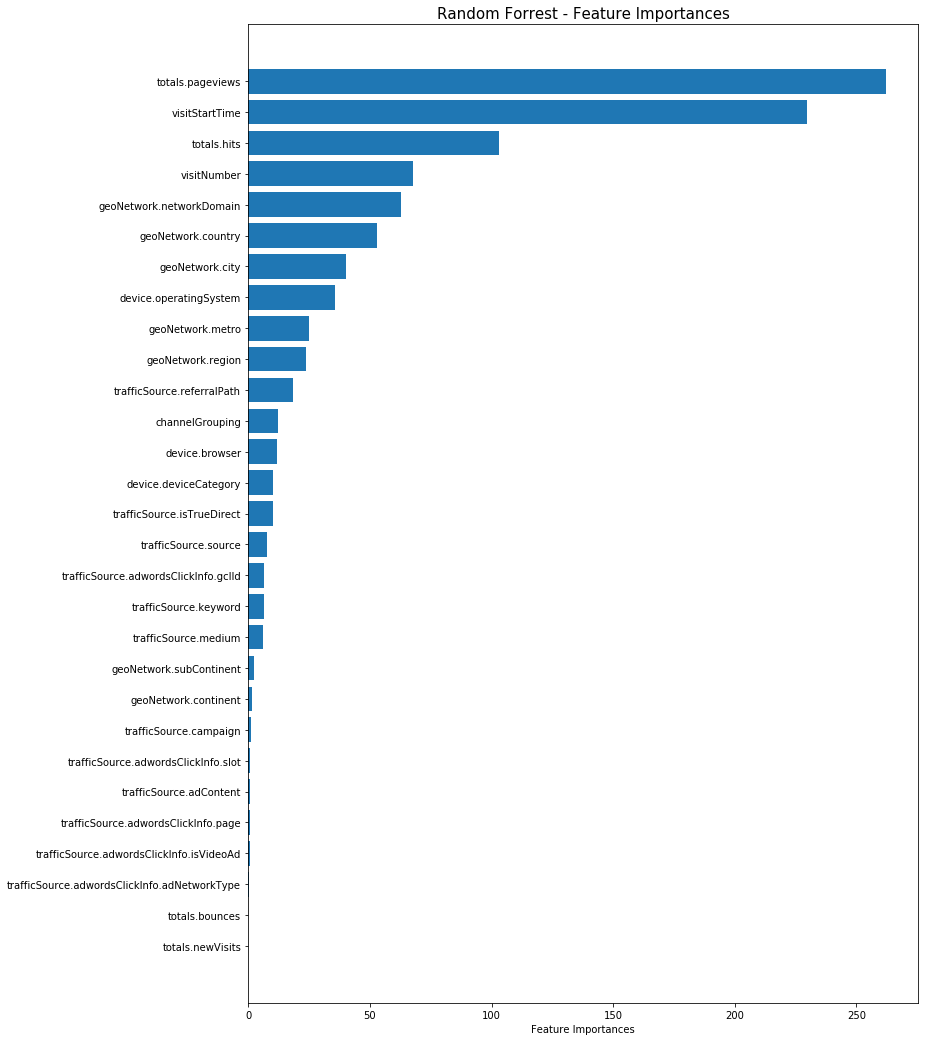

In [37]:
features = dev_X.columns
importances = rf.feature_importances_
indices = np.argsort(importances)
fig, ax = plt.subplots(figsize=(12,18))
plt.title('Random Forrest - Feature Importances', fontsize=15)
plt.barh(range(len(indices)), importances[indices]*1000,height=0.8)
plt.yticks(range(len(indices)), [features[i] for i in indices])
ax.grid(False)
plt.xlabel('Feature Importances')
plt.show()

### LightGBM Model 

In [38]:
# custom function to run light gbm model
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse", 
        "num_leaves" : 30,
        "min_child_samples" : 100,
        "learning_rate" : 0.1,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.5,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=100)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    pred_val_y = model.predict(val_X, num_iteration=model.best_iteration)
    return pred_test_y, model, pred_val_y

# Training the model #
pred_test, model, pred_val = run_lgb(dev_X, dev_y, val_X, val_y, test_X)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.46781
Early stopping, best iteration is:
[56]	valid_0's rmse: 1.46444


### LightGBM Prediction for sum of log of revenue for each user

In [39]:
pred_val[pred_val<0] = 0
val_pred_df = pd.DataFrame({"fullVisitorId":val_df["fullVisitorId"].values})
val_pred_df["transactionRevenue"] = val_df["totals.transactionRevenue"].values
val_pred_df["PredictedRevenue"] = np.expm1(pred_val)
val_pred_df = val_pred_df.groupby("fullVisitorId")["transactionRevenue", "PredictedRevenue"].sum().reset_index()
print(np.sqrt(metrics.mean_squared_error(np.log1p(val_pred_df["transactionRevenue"].values), np.log1p(val_pred_df["PredictedRevenue"].values))))

1.4927178762889366


In [40]:
val_pred_df.head()

,fullVisitorId,transactionRevenue,PredictedRevenue
0,0000000259678714014,0.0,1.106884
1,0000049363351866189,0.0,0.000000
2,0000053049821714864,0.0,0.000000
3,0000059488412965267,0.0,0.002561
4,0000062267706107999,0.0,0.005492


###  LightGBM Feature importance visualization

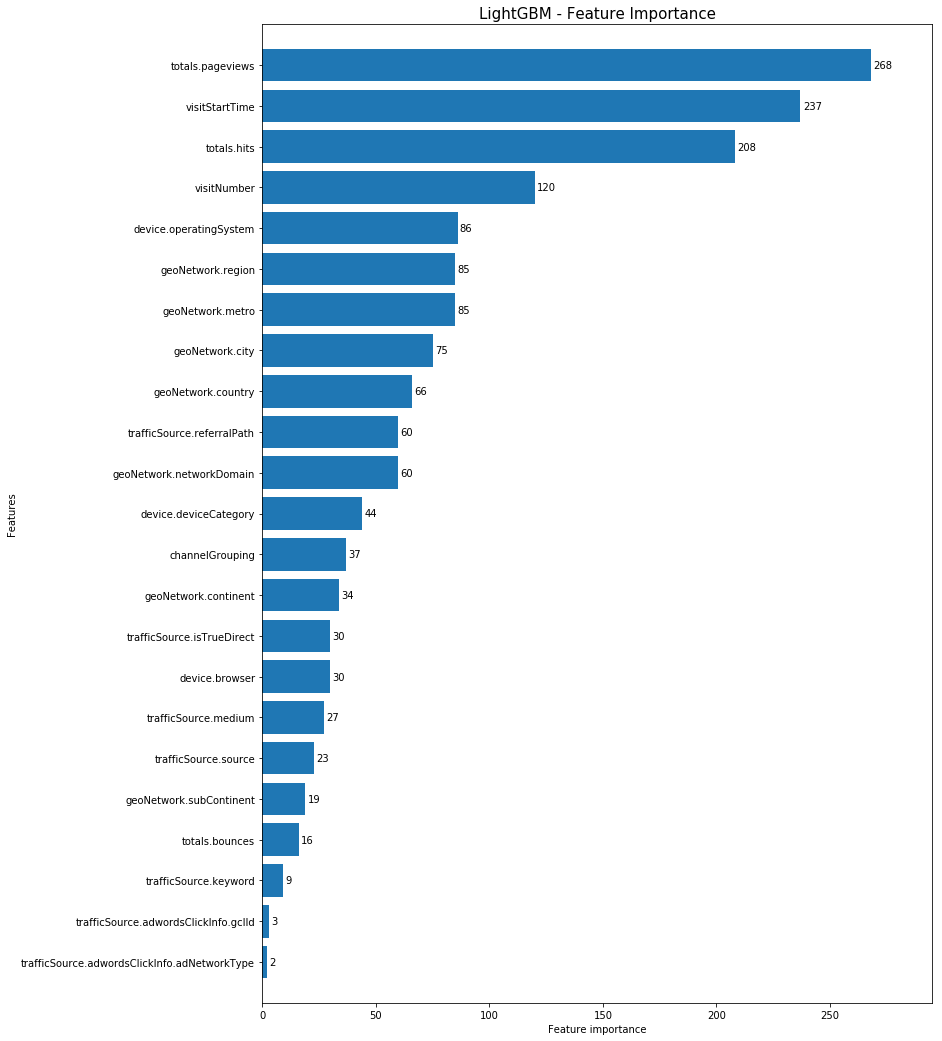

In [41]:
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

In [42]:
y_pred_df.head()

,fullVisitorId,transactionRevenue,PredictedRevenue
0,0000000259678714014,0.0,0.0
1,0000049363351866189,0.0,0.0
2,0000053049821714864,0.0,0.0
3,0000059488412965267,0.0,0.0
4,0000062267706107999,0.0,0.0


## Refinement 

In [43]:
# custom function to run light gbm model
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse", 
        "num_leaves" : 40,
        "min_child_samples" : 250,
        "learning_rate" : 0.01,
        "bagging_fraction" : 0.6,
        "feature_fraction" : 0.5,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=100)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    pred_val_y = model.predict(val_X, num_iteration=model.best_iteration)
    return pred_test_y, model, pred_val_y

# Training the model #
pred_test, model, pred_val = run_lgb(dev_X, dev_y, val_X, val_y, test_X)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.52334
[200]	valid_0's rmse: 1.47883
[300]	valid_0's rmse: 1.46728
[400]	valid_0's rmse: 1.46413
[500]	valid_0's rmse: 1.46369
[600]	valid_0's rmse: 1.46336
[700]	valid_0's rmse: 1.46316
Early stopping, best iteration is:
[687]	valid_0's rmse: 1.46302


In [44]:
pred_val[pred_val<0] = 0
val_pred_df = pd.DataFrame({"fullVisitorId":val_df["fullVisitorId"].values})
val_pred_df["transactionRevenue"] = val_df["totals.transactionRevenue"].values
val_pred_df["PredictedRevenue"] = np.expm1(pred_val)
val_pred_df = val_pred_df.groupby("fullVisitorId")["transactionRevenue", "PredictedRevenue"].sum().reset_index()
print("The LightGBM Model's RMSE score for natural log of the sum of all transaction by the user")
print('Root Mean Squared Error:',np.sqrt(metrics.mean_squared_error(np.log1p(val_pred_df["transactionRevenue"].values), np.log1p(val_pred_df["PredictedRevenue"].values))))

The LightGBM Model's RMSE score for natural log of the sum of all transaction by the user
Root Mean Squared Error: 1.4902466376284929


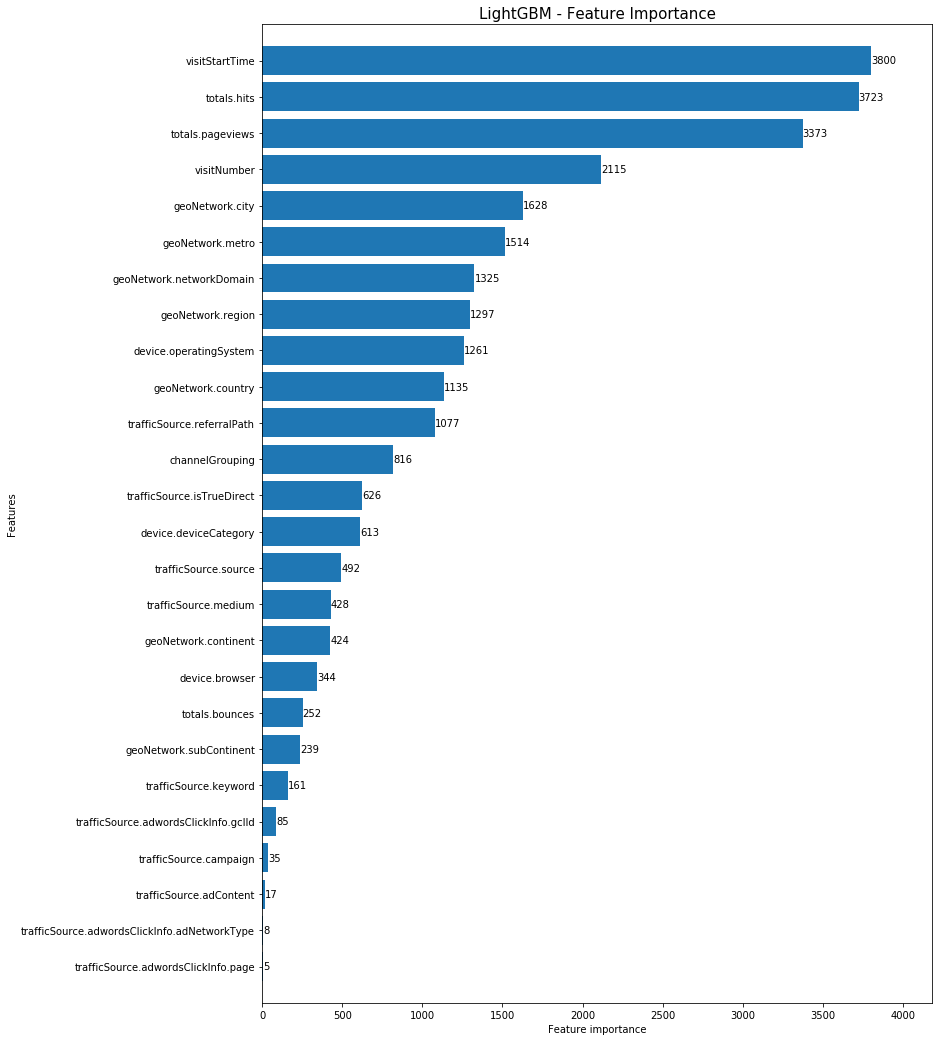

In [45]:
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

## Validation Dataset Timeseries visualization 

In [46]:
pred_val[pred_val<0] = 0
val_pred_df = pd.DataFrame({"date":val_df["date"].values})
val_pred_df["transactionRevenue"] = val_df["totals.transactionRevenue"].values
val_pred_df["PredictedRevenue"] = np.expm1(pred_val)
val_pred_df = val_pred_df.groupby("date")["transactionRevenue", "PredictedRevenue"].sum().reset_index()


time_rev = val_pred_df.groupby('date')['transactionRevenue'].sum()
time_rev_pre = val_pred_df.groupby('date')['PredictedRevenue'].sum()


time_rev = time_rev.sort_index()
time_rev_pre = time_rev_pre.sort_index()

time_rev= go.Scatter( x=time_rev.index,y=time_rev.values,showlegend=False)
time_rev_pre= go.Scatter( x=time_rev_pre.index,y=time_rev_pre.values,showlegend=False)


fig = tools.make_subplots(rows=2, cols=1, vertical_spacing=0.08,subplot_titles=["Date - Transaction Revenue","Date - Predicted Revenue"])
fig.append_trace(time_rev, 1, 1)
fig.append_trace(time_rev_pre, 2, 1)

fig['layout'].update(height=800, width=1000, paper_bgcolor='rgb(233,233,233)', title="Date Plots")
py.iplot(fig, filename='date-plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]



## Test Dataset Timeseries visualization 

In [49]:
pred_test[pred_test<0] = 0
val_pred_ = pd.DataFrame({"date":test["date"].values})
val_pred_["transactionRevenue"] = test["totals.transactionRevenue"].values
val_pred_["PredictedRevenue"] = np.expm1(pred_test)
val_pred_ = val_pred_.groupby("date")["transactionRevenue", "PredictedRevenue"].sum().reset_index()


time_re = val_pred_.groupby('date')['transactionRevenue'].sum()
time_rev_pr = val_pred_.groupby('date')['PredictedRevenue'].sum()


time_re = time_re.sort_index()
time_rev_pr = time_rev_pr.sort_index()

time_re= go.Scatter( x=time_re.index,y=time_re.values,showlegend=False)
time_rev_pr= go.Scatter( x=time_rev_pr.index,y=time_rev_pr.values,showlegend=False)


fig = tools.make_subplots(rows=2, cols=1, vertical_spacing=0.08,subplot_titles=["Date - Transaction Revenue","Date - Predicted Revenue"])
fig.append_trace(time_re, 1, 1)
fig.append_trace(time_rev_pr, 2, 1)

fig['layout'].update(height=800, width=1000, paper_bgcolor='rgb(233,233,233)', title="Date Plots")
py.iplot(fig, filename='date-plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]



In [52]:
pred_test[pred_test<0] = 0
val_pred_test = pd.DataFrame({"fullVisitorId":test["fullVisitorId"].values})
val_pred_test["transactionRevenue"] = test["totals.transactionRevenue"].values
val_pred_test["PredictedRevenue"] = np.expm1(pred_test)
val_pred_test = val_pred_test.groupby("fullVisitorId")["transactionRevenue", "PredictedRevenue"].sum().reset_index()
print("Test Dataset :")
print("The LightGBM Model's RMSE score for natural log of the sum of all transaction by the user")
print('Root Mean Squared Error:',np.sqrt(metrics.mean_squared_error(np.log1p(val_pred_test["transactionRevenue"].values), np.log1p(val_pred_test["PredictedRevenue"].values))))

Test Dataset :
The LightGBM Model's RMSE score for natural log of the sum of all transaction by the user
Root Mean Squared Error: 1.7391857724099973
